In [2]:
!pip install arch

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 928.2/928.2 kB 1.5 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

In [5]:
# Đọc dữ liệu
data = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\VCB.csv")
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Chọn cột giá đóng cửa
close_prices = data['close']
train_size = int(len(close_prices) * 0.8)
train, test = close_prices[:train_size], close_prices[train_size:]


In [8]:
rf_model = RandomForestRegressor()
rf_model.fit(np.arange(len(train)).reshape(-1, 1), train)
rf_predictions = rf_model.predict(np.arange(len(train), len(train) + len(test)).reshape(-1, 1))
rf_mse = mean_squared_error(test, rf_predictions)


In [9]:
xgb_model = XGBRegressor()
xgb_model.fit(np.arange(len(train)).reshape(-1, 1), train)
xgb_predictions = xgb_model.predict(np.arange(len(train), len(train) + len(test)).reshape(-1, 1))
xgb_mse = mean_squared_error(test, xgb_predictions)


In [10]:
train_lstm = np.array(train).reshape(-1, 1)
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(1, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(train_lstm[:-1].reshape(-1, 1, 1), train_lstm[1:], epochs=200, verbose=0)
lstm_predictions = model_lstm.predict(np.array(test).reshape(-1, 1, 1)).flatten()
lstm_mse = mean_squared_error(test, lstm_predictions)


16/16 [==============================] - 0s 2ms/step


In [11]:
arima_model = ARIMA(train, order=(5, 1, 0))
arima_model_fit = arima_model.fit()
arima_predictions = arima_model_fit.forecast(steps=len(test))
arima_mse = mean_squared_error(test, arima_predictions)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [12]:
garch_model = arch_model(train, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp="off")
garch_forecast = garch_fit.forecast(horizon=len(test))
garch_predictions = garch_forecast.mean.values[-1, :]
garch_mse = mean_squared_error(test, garch_predictions)


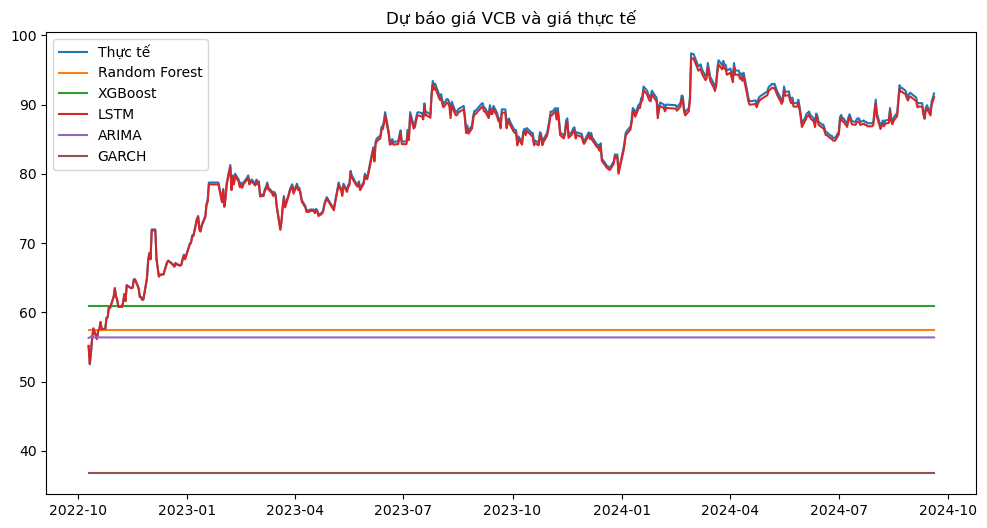

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Thực tế')
plt.plot(test.index, rf_predictions, label='Random Forest')
plt.plot(test.index, xgb_predictions, label='XGBoost')
plt.plot(test.index, lstm_predictions, label='LSTM')
plt.plot(test.index, arima_predictions, label='ARIMA')
plt.plot(test.index, garch_predictions, label='GARCH')
plt.legend()
plt.title("Dự báo giá VCB và giá thực tế")
plt.show()


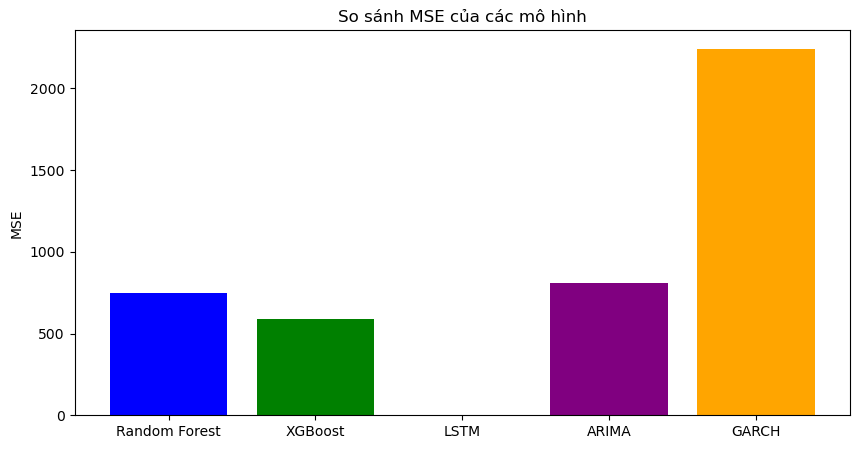

In [14]:
mse_values = [rf_mse, xgb_mse, lstm_mse, arima_mse, garch_mse]
models = ['Random Forest', 'XGBoost', 'LSTM', 'ARIMA', 'GARCH']

plt.figure(figsize=(10, 5))
plt.bar(models, mse_values, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylabel('MSE')
plt.title('So sánh MSE của các mô hình')
plt.show()


In [15]:
print("MSE của từng mô hình:")
print(f"Random Forest MSE: {rf_mse}")
print(f"XGBoost MSE: {xgb_mse}")
print(f"LSTM MSE: {lstm_mse}")
print(f"ARIMA MSE: {arima_mse}")
print(f"GARCH MSE: {garch_mse}")

MSE của từng mô hình:
Random Forest MSE: 750.3447728406582
XGBoost MSE: 587.2609614207503
LSTM MSE: 0.1644968228853587
ARIMA MSE: 806.6360761258952
GARCH MSE: 2242.1837851338096
